In [1]:
import preprocess
import knowledgeGraph
import spacy
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

nlp = spacy.load('en_core_web_md')
nlp.add_pipe("merge_entities")
nlp.add_pipe("merge_noun_chunks")
nlp.add_pipe('coreferee')

c:\Users\zisak\anaconda3\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
c:\Users\zisak\anaconda3\Lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
# candidate_sentences = pd.read_csv("wiki_sentences_v2.csv")
# candidate_sentences.shape

In [3]:
pp = preprocess.preprocess(nlp)
kg = knowledgeGraph.KnowledgeGraph(nlp)


In [32]:
text = """Messi played for Barcelona.
Barcelona is a football club. Barcelona beats Real Madrid.
Real Madrid is in Spain. Spain is in Europe.
"""
question = "Who is Lionel Messi?"

sentences, _, _ = pp.process_question_context(question, text)
contextDF = kg.join_sentences_facts(sentences)
contextDF


,Subject,Relation,Objects,States,Times,Locations
0,Barcelona,be,[a football club],[],[],[]
1,Barcelona,beat,[Real Madrid],[],[],[Real Madrid]
2,Messi,play,[],[for Barcelona],[],[Barcelona]
3,Real Madrid,be,[],[in Spain],[],"[Real Madrid, Spain]"
4,Spain,be,[],[in Europe],[],"[Spain, Europe]"


In [33]:
# contextDF = kg.join_sentences_facts(candidate_sentences['sentence'][10:20])
# contextDF

In [34]:
# if there is more than 1 element in Objects column, take the first one and if empty list make it ""
updatedDF = contextDF.copy()
updatedDF['Objects'] = updatedDF['Objects'].apply(lambda x: x[0] if len(x) > 0 else "")
updatedDF['States'] = updatedDF['States'].apply(lambda x: x[0] if len(x) > 0 else "")
updatedDF['Times'] = updatedDF['Times'].apply(lambda x: x[0] if len(x) > 0 else "")
updatedDF['Locations'] = updatedDF['Locations'].apply(lambda x: x[0] if len(x) > 0 else "")
updatedDF = updatedDF[~((updatedDF["Subject"] == "Unknown") & (updatedDF["Objects"].apply(len) == 0) & (updatedDF["States"].apply(len) == 0) & (updatedDF["Times"].apply(len) == 0) & (updatedDF["Locations"].apply(len) == 0))]
updatedDF = updatedDF.reset_index(drop=True)
updatedDF

,Subject,Relation,Objects,States,Times,Locations
0,Barcelona,be,a football club,,,
1,Barcelona,beat,Real Madrid,,,Real Madrid
2,Messi,play,,for Barcelona,,Barcelona
3,Real Madrid,be,,in Spain,,Real Madrid
4,Spain,be,,in Europe,,Spain


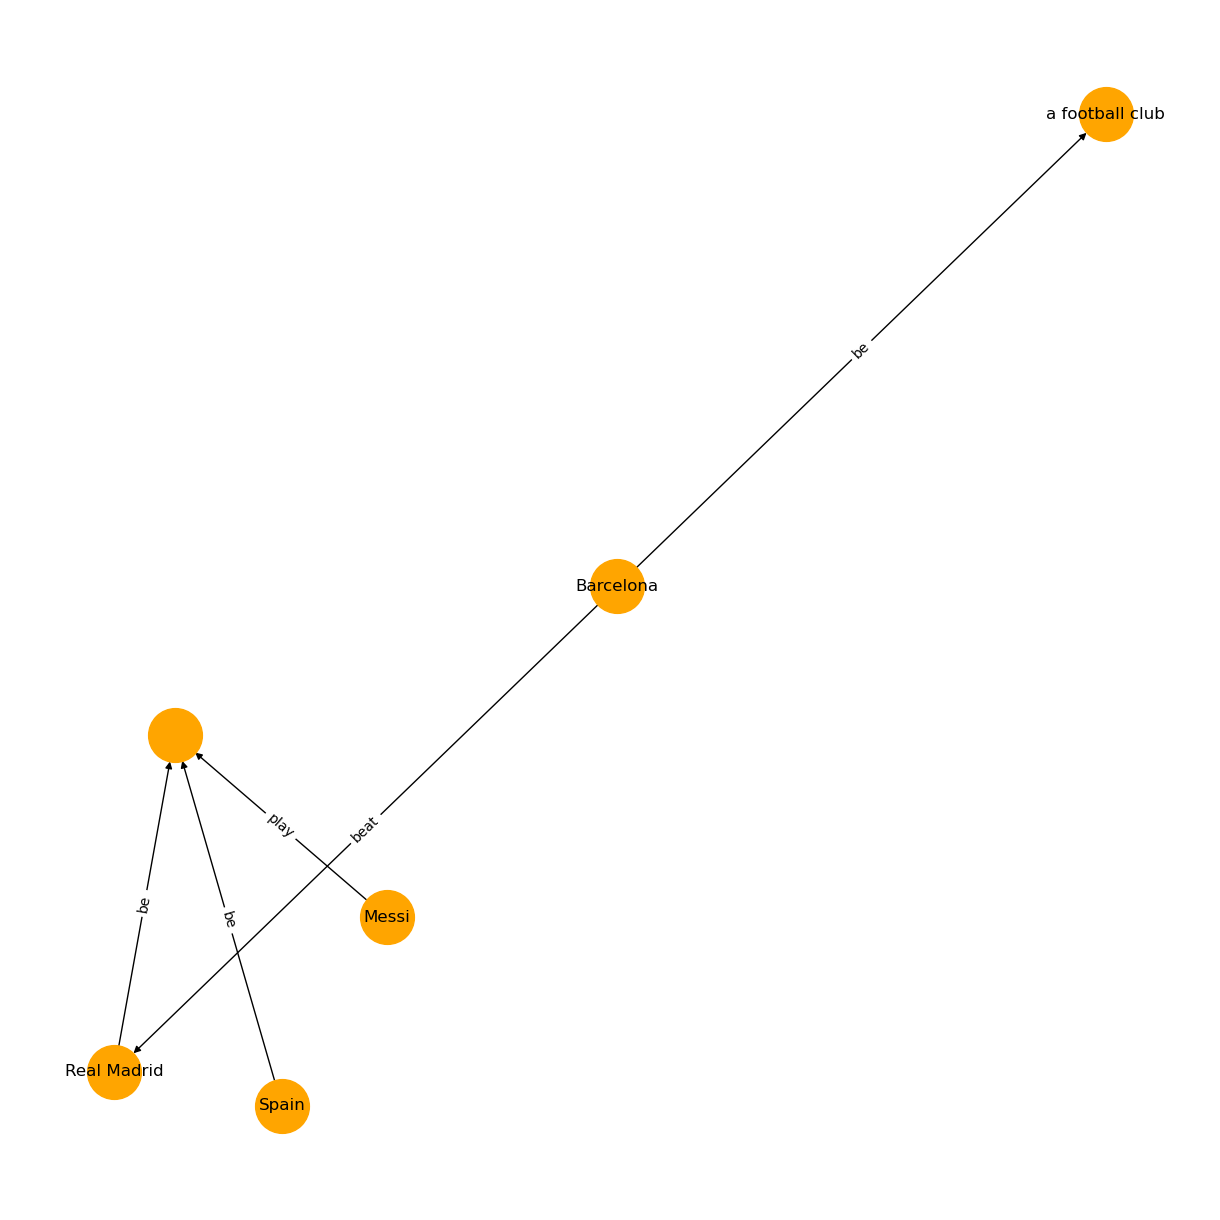

In [35]:
import matplotlib.pyplot as plt

# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(updatedDF, "Subject", "Objects", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='orange', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)

# Convert MultiDiGraph to DiGraph
G = nx.DiGraph(G)

edge_labels = nx.get_edge_attributes(G, 'Relation')
nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels)

plt.show()